In [99]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
os.environ['TWITTER_TOKEN'] = ''

camara_base_url = 'https://dadosabertos.camara.leg.br/api/v2/'

# Dados Públicos Câmara dos Deputados


In [41]:
url = f'{camara_base_url}/deputados'
response = requests.get(url)
if not response.ok: # != 200:
    raise Exception('Nao foi possivel recuperar os dados')

df_deputados = pd.DataFrame().from_dict(json.loads(response.text)['dados'])
print(df_deputados.shape)
df_deputados.head()

(513, 9)


,id,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email
0,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abiliosantana@camara.leg.br
1,204521,https://dadosabertos.camara.leg.br/api/v2/depu...,Abou Anni,UNIÃO,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abouanni@camara.leg.br
2,204379,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,PROS,https://dadosabertos.camara.leg.br/api/v2/part...,AP,56,https://www.camara.leg.br/internet/deputado/ba...,dep.acaciofavacho@camara.leg.br
3,204560,https://dadosabertos.camara.leg.br/api/v2/depu...,Adolfo Viana,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.adolfoviana@camara.leg.br
4,204528,https://dadosabertos.camara.leg.br/api/v2/depu...,Adriana Ventura,NOVO,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,https://www.camara.leg.br/internet/deputado/ba...,dep.adrianaventura@camara.leg.br


## Bancadas de Partidos 

Text(0.5, 1.0, 'Tamanho da Bancada dos Partidos')

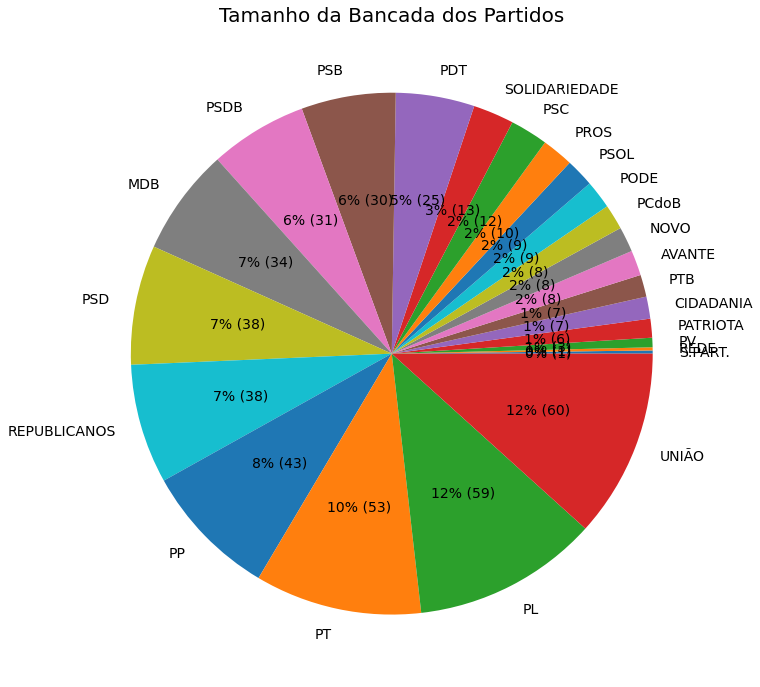

In [3]:
plt.figure(figsize=(12,12))

def autopct_label(x):
    return '{:.0f}% ({:.0f})'.format(x, total*x/100)

total = df_deputados.shape[0]

(df_deputados.groupby('siglaPartido')
             .nome
             .nunique()
             .sort_values()
             .plot(kind='pie', startangle=0, fontsize=14, autopct=autopct_label)
)
plt.ylabel('')
plt.title(f'Tamanho da Bancada dos Partidos', fontsize=20)


## Despesas dos Deputados

In [87]:
list_expenses = []
idLegislatura = '56', # depudatos eleitos em 2018,
anoDespesa = '2020'
maxItens = '100' # somente suporta ate 100

for id in tqdm(df_deputados.id.unique()):
    url = f'{camara_base_url}/deputados/{id}/despesas'
    params = {
        'idLegislatura': idLegislatura, 
        'ano': anoDespesa,
        'itens': maxItens,
    }
    # Execucao da primeira pagina de resultados.
    response = requests.get(url, params)
    df_resp = pd.DataFrame().from_dict(json.loads(response.text)['dados'])
    df_resp['id'] = id
    list_expenses.append(df_resp)
    # Link para proxima pagina
    df_links = pd.DataFrame().from_dict(json.loads(response.text)['links'])
    df_links = df_links.set_index('rel').href
    
    while 'next' in df_links.index:
        response = requests.get(df_links['next'])
        df_resp = pd.DataFrame().from_dict(json.loads(response.text)['dados'])
        df_resp['id'] = id
        list_expenses.append(df_resp)
        # Link para proxima pagina
        df_links = pd.DataFrame().from_dict(json.loads(response.text)['links'])
        df_links = df_links.set_index('rel').href
        
df_expenses = pd.concat(list_expenses)

# Merge para trazer as informacoes de sigla e afins do deputado
df_expenses = df_expenses.merge(df_deputados, on=['id'])
df_expenses.head()

100%|██████████| 513/513 [09:42<00:00,  1.13s/it]


,ano,mes,tipoDespesa,codDocumento,tipoDocumento,codTipoDocumento,dataDocumento,numDocumento,valorDocumento,urlDocumento,...,parcela,id,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email
0,2020.0,1.0,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,7004672.0,Nota Fiscal,0.0,2020-01-15,417815556,132.76,https://www.camara.leg.br/cota-parlamentar/doc...,...,0.0,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abiliosantana@camara.leg.br
1,2020.0,2.0,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,7023227.0,Nota Fiscal,0.0,2020-02-12,423977595,162.27,https://www.camara.leg.br/cota-parlamentar/doc...,...,0.0,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abiliosantana@camara.leg.br
2,2020.0,3.0,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,7049816.0,Nota Fiscal,0.0,2020-03-13,430442113,284.36,https://www.camara.leg.br/cota-parlamentar/doc...,...,0.0,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abiliosantana@camara.leg.br
3,2020.0,4.0,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,7049817.0,Nota Fiscal,0.0,2020-04-13,437017526,80.96,https://www.camara.leg.br/cota-parlamentar/doc...,...,0.0,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abiliosantana@camara.leg.br
4,2020.0,5.0,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,7060152.0,Nota Fiscal,0.0,2020-05-13,443686627,65.32,https://www.camara.leg.br/cota-parlamentar/doc...,...,0.0,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abiliosantana@camara.leg.br


# Informação Disponível de Despesas 

In [98]:
df_expenses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149283 entries, 0 to 149282
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ano                149283 non-null  float64
 1   mes                149283 non-null  float64
 2   tipoDespesa        149283 non-null  object 
 3   codDocumento       149283 non-null  float64
 4   tipoDocumento      149283 non-null  object 
 5   codTipoDocumento   149283 non-null  float64
 6   dataDocumento      149283 non-null  object 
 7   numDocumento       149283 non-null  object 
 8   valorDocumento     149283 non-null  float64
 9   urlDocumento       99861 non-null   object 
 10  nomeFornecedor     149283 non-null  object 
 11  cnpjCpfFornecedor  149283 non-null  object 
 12  valorLiquido       149283 non-null  float64
 13  valorGlosa         149283 non-null  float64
 14  numRessarcimento   149283 non-null  object 
 15  codLote            149283 non-null  float64
 16  pa

### Valor Liquido Total e Por Deputado 

In [95]:
# df_expenses.groupby(['nome', 'siglaPartido']).id.count().sort_values(ascending=False)

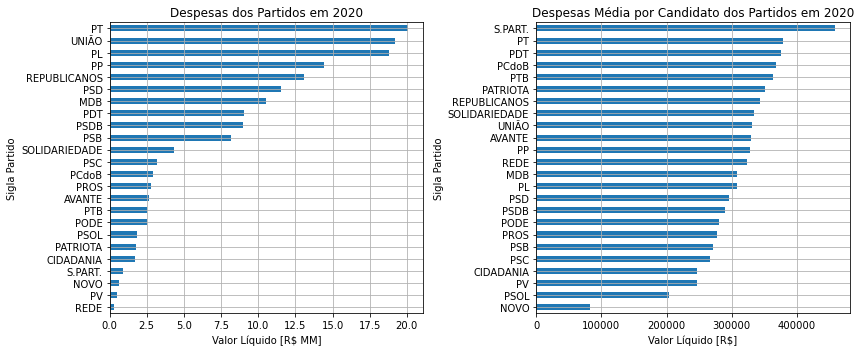

In [88]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
X =(df_expenses.groupby('siglaPartido')
            .valorLiquido
            .sum()
            .sort_values())
(X / 1e6).plot.barh()
plt.ylabel('Sigla Partido')
plt.xlabel('Valor Líquido [R$ MM]')
plt.grid()
expense_years = '-'.join(df_expenses.ano.astype(str).str.replace('.0','',regex=False).unique())
plt.title(f"Despesas dos Partidos em {expense_years}")

plt.subplot(1,2,2)
Xn = df_deputados.groupby('siglaPartido', as_index=False).nome.nunique()
Xn = Xn.merge(X.reset_index(), on='siglaPartido')
Xn['ValorMedioPorCandidato'] = Xn['valorLiquido'] / Xn['nome']
(Xn.set_index('siglaPartido')
   .sort_values('ValorMedioPorCandidato')
   .ValorMedioPorCandidato
   .plot
   .barh()
)
plt.ylabel('Sigla Partido')
plt.xlabel('Valor Líquido [R$]')
plt.grid()
expense_years = '-'.join(df_expenses.ano.astype(str).str.replace('.0','',regex=False).unique())
plt.title(f"Despesas Média por Candidato dos Partidos em {expense_years}")
plt.tight_layout()

### Tipos de Despesas de Maior Valor 

Text(0.5, 1.0, 'Valor Líquido por Tipo de Despesa em 2020')

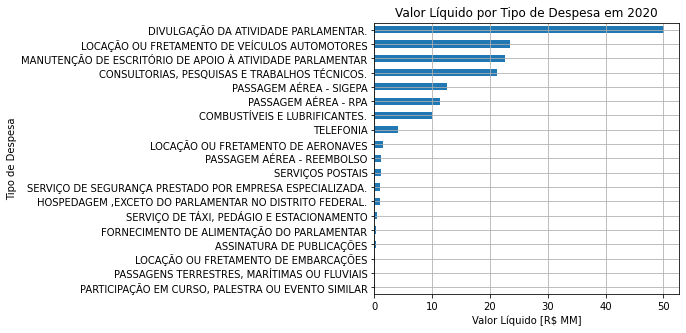

In [89]:
df_expenses.tipoDespesa.unique()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
X =(df_expenses.groupby('tipoDespesa')
            .valorLiquido
            .sum()
            .sort_values())
(X / 1e6).plot.barh()
plt.ylabel('Tipo de Despesa')
plt.xlabel('Valor Líquido [R$ MM]')
plt.grid()
expense_years = '-'.join(df_expenses.ano.astype(str).str.replace('.0','',regex=False).unique())
plt.title(f"Valor Líquido por Tipo de Despesa em {expense_years}")


# Fact Checking 

Utilizar os dados públicos da câmara para verificar notícias da mídia.

Exemplo: 
https://congressoemfoco.uol.com.br/projeto-bula/reportagem/os-11-deputados-que-mais-faltaram-em-2019/

Análise:
Utilizar as APIs públicas para verificar os números da notícia.



In [5]:
camara_base_url
dataInicio = '2019-01-01'
dataFim    = '2019-12-31'
idProposicao = '1' # Queremos saber o nome de qualquer deputado que tenha votado, independente de proposicao


'https://dadosabertos.camara.leg.br/api/v2/'

In [7]:
url = f'{camara_base_url}/votacoes'
params = {
    'dataInicio': dataInicio, 
    'dataFim': dataFim, 
    'idProposicao': idProposicao, 
}

response = requests.get(url)

if not response.ok: # != 200:
    raise Exception('Nao foi possivel recuperar os dados')
df_resp = pd.DataFrame().from_dict(json.loads(response.text)['dados'])
df_resp['id'] = id_deputado
df_resp



In [10]:
# df_deputados.id.unique()
url = f'{camara_base_url}/deputados/{id_deputado}/despesas'

In [45]:
df_deputados.head()

,id,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email
0,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abiliosantana@camara.leg.br
1,204521,https://dadosabertos.camara.leg.br/api/v2/depu...,Abou Anni,UNIÃO,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abouanni@camara.leg.br
2,204379,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,PROS,https://dadosabertos.camara.leg.br/api/v2/part...,AP,56,https://www.camara.leg.br/internet/deputado/ba...,dep.acaciofavacho@camara.leg.br
3,204560,https://dadosabertos.camara.leg.br/api/v2/depu...,Adolfo Viana,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.adolfoviana@camara.leg.br
4,204528,https://dadosabertos.camara.leg.br/api/v2/depu...,Adriana Ventura,NOVO,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,https://www.camara.leg.br/internet/deputado/ba...,dep.adrianaventura@camara.leg.br


In [48]:
response
df_links = pd.DataFrame().from_dict(json.loads(response.text)['links'])

,rel,href
0,self,https://dadosabertos.camara.leg.br/api/v2//dep...
1,next,https://dadosabertos.camara.leg.br/api/v2//dep...
2,first,https://dadosabertos.camara.leg.br/api/v2//dep...
3,last,https://dadosabertos.camara.leg.br/api/v2//dep...


# API Twitter 

In [110]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """
    r.headers["Authorization"] = f"Bearer {os.environ['TWITTER_TOKEN']}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params, verify=False)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()


In [109]:
#Change to the endpoint you want to collect data from
search_url = "https://api.twitter.com/2/tweets/search/recent"
# search_url = "https://api.twitter.com/2/tweets/search/all" 
keyword = 'melhor vinho tinto lang:pt'
start_time = "2022-03-01T00:00:00.000Z"
end_time = "2022-03-20T00:00:00.000Z"
max_results = 20

query_params = {'query': keyword,
#                 'start_time': start_time,
#                 'end_time': end_time,
#                 'max_results': max_results,
                'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                'next_token': {}}


json_response = connect_to_endpoint(search_url, query_params)
print(json.dumps(json_response, indent=4, sort_keys=True))

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet-ead\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.twitter.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


200
{
    "data": [
        {
            "author_id": "1293637663426322434",
            "conversation_id": "1506375244755390466",
            "created_at": "2022-03-22T21:00:20.000Z",
            "id": "1506375244755390466",
            "lang": "pt",
            "public_metrics": {
                "like_count": 1,
                "quote_count": 0,
                "reply_count": 0,
                "retweet_count": 0
            },
            "reply_settings": "everyone",
            "source": "mLabs - Gest\u00e3o de Redes Sociais",
            "text": "O friozinho j\u00e1 est\u00e1 dando as caras por aqui, e nada melhor do que um vinho pra curtir esse clima! \ud83c\udf77\nAl\u00e9m dos nossos drinks e chopps gelados, voc\u00ea tamb\u00e9m pode apreciar um bom vinho Plan B, nas op\u00e7\u00f5es Ros\u00e9, Branco e Tinto. \ud83d\ude09\n\n#BackstageAhoy #VinhoPlanB #TemporadaDeInverno https://t.co/dBrJiPReOa"
        },
        {
            "author_id": "1407530909692215304",
         